# **Multi-Layer Perceptron (MLP) Classification**

## **Project Overview**

This notebook implements a Multi-Layer Perceptron (MLP) neural network from scratch for regression on a Kaggle competition dataset.

**Authors:** João Pedro Rodrigues, Matheus Castelucci, Rodrigo Medeiros

## **1. Dataset Selection**

### **Dataset Information**

**Name:** Predict Calorie Expenditure

**Source:** [Kaggle Playground Series S5E5](https://www.kaggle.com/competitions/playground-series-s5e5)

**Original Dataset:** [Calories Burnt Prediction](https://www.kaggle.com/datasets/ruchikakumbhar/calories-burnt-prediction)

**Size:**

- Training set: 750,000 rows x 9 columns

- Test set: 250,000 rows x 8 columns

- Features: 7 features (6 numerical, 1 categorical)

- Target: Continuous (calories burned)

**Why this dataset?**

- Realistic regression problem with a continuous target variable.

- Large enough dataset to train a neural network.

- Good opportunity to practice feature engineering and preprocessing.

In [40]:
# Basic imports & reproducibility
import os
import random
from pathlib import Path
import warnings

import math
import numpy as np
import pandas as pd
import itertools
import copy

# plotting
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import MaxNLocator

# stats / util
from scipy import stats
from tqdm.auto import tqdm

# preprocessing & modeling
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.utils.class_weight import compute_class_weight

# metrics
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, roc_auc_score, roc_curve,
    precision_recall_curve, average_precision_score, classification_report
)

# notebook display
%matplotlib inline
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 200)
warnings.filterwarnings('ignore')

# plotting style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_context('notebook')

# seeds for reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)

## **2. Dataset Explanation**

In [41]:
# Load dataset
DATA_DIR = Path("data")
train = pd.read_csv(DATA_DIR / "train.csv")
test = pd.read_csv(DATA_DIR / "test.csv")

print("Dataset Shape:")
print(f"  Training: {train.shape}")
print(f"  Test: {test.shape}")

print("\nFirst 5 rows:")
display(train.head())

print("\nData Types:")
print(train.dtypes)

Dataset Shape:
  Training: (750000, 9)
  Test: (250000, 8)

First 5 rows:


,id,Sex,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories
0,0,male,36,189.0,82.0,26.0,101.0,41.0,150.0
1,1,female,64,163.0,60.0,8.0,85.0,39.7,34.0
2,2,female,51,161.0,64.0,7.0,84.0,39.8,29.0
3,3,male,20,192.0,90.0,25.0,105.0,40.7,140.0
4,4,female,38,166.0,61.0,25.0,102.0,40.6,146.0



Data Types:
id              int64
Sex            object
Age             int64
Height        float64
Weight        float64
Duration      float64
Heart_Rate    float64
Body_Temp     float64
Calories      float64
dtype: object


### **Feature Descriptions**

**Numerical Features(6):**

- `Age`: Age of the individual (years)
- `Height`: Height of the individual (cm)
- `Weight`: Weight of the individual (kg)
- `Duration`: Duration of the activity (minutes)
- `Heart_rate`: Average heart rate during the activity (bpm)
- `Body_temp`: Body temperature during the activity (°C)

**Categorical Feature(1):**

- `Sex`: Biological sex of the individual (Male or Female)

**Target Variable:**

- `Calories`: Total calories burned during the activity (continuous)

In [42]:
# Identify feature types
target_col = 'Calories'
id_col = 'id'

numerical_features = train.select_dtypes(include=['number']).columns.tolist()
numerical_features = [col for col in numerical_features if col not in [id_col, target_col]]

categorical_features = train.select_dtypes(include=['object']).columns.tolist()

print(f"Numerical features ({len(numerical_features)}): {numerical_features}")
print(f"\nCategorical features ({len(categorical_features)}): {categorical_features}")

Numerical features (6): ['Age', 'Height', 'Weight', 'Duration', 'Heart_Rate', 'Body_Temp']

Categorical features (1): ['Sex']


### **Numerical Feature Summary**

In [43]:
# Summary statistics
display(train[numerical_features].describe())

# Check for missing values
print("Missing Values:")
print(train.isnull().sum())

# Check for duplicates
print(f"\nDuplicate Rows: {train.duplicated().sum()}")

,Age,Height,Weight,Duration,Heart_Rate,Body_Temp
count,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000
mean,41.420404,174.697685,75.145668,15.421015,95.483995,40.036253
std,15.175049,12.824496,13.982704,8.354095,9.449845,0.779875
min,20.000000,126.000000,36.000000,1.000000,67.000000,37.100000
25%,28.000000,164.000000,63.000000,8.000000,88.000000,39.600000
50%,40.000000,174.000000,74.000000,15.000000,95.000000,40.300000
75%,52.000000,185.000000,87.000000,23.000000,103.000000,40.700000
max,79.000000,222.000000,132.000000,30.000000,128.000000,41.500000


Missing Values:
id            0
Sex           0
Age           0
Height        0
Weight        0
Duration      0
Heart_Rate    0
Body_Temp     0
Calories      0
dtype: int64

Duplicate Rows: 0


In [44]:
# Check for outliers (beyond 3 standard deviations)
outlier_summary = {}
for col in numerical_features:
    z = np.abs(stats.zscore(train[col]))
    outlier_summary[col] = (z > 3).mean() * 100

outlier_df = pd.DataFrame.from_dict(outlier_summary, orient='index', columns=['% Outliers'])
display(outlier_df.sort_values('% Outliers', ascending=False))

,% Outliers
Body_Temp,0.449067
Heart_Rate,0.023333
Weight,0.013867
Height,0.005067
Age,0.000000
Duration,0.000000


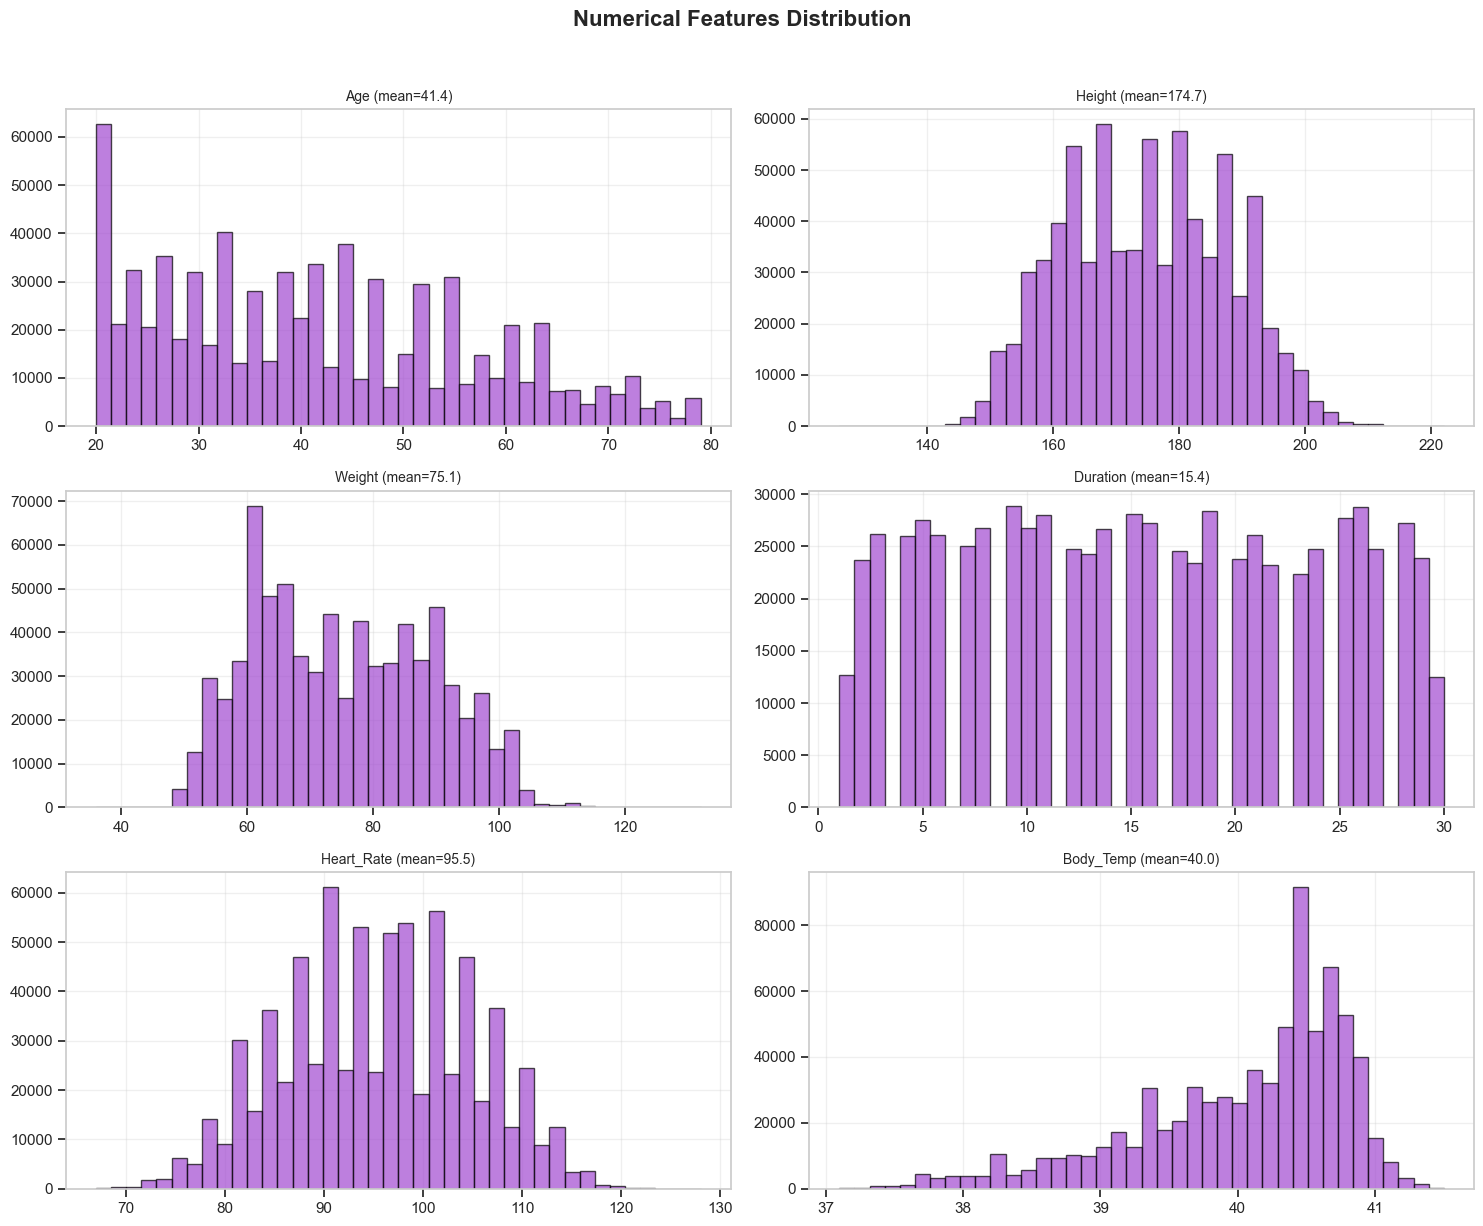

In [45]:
fig, axes = plt.subplots(3, 2, figsize=(15, 12))
axes = axes.flatten()

for i, col in enumerate(numerical_features):
    data = train[col].dropna()
    # histogram with density overlay (optional)
    axes[i].hist(data, bins=40, color="#a149d1", edgecolor="black", alpha=0.7)
    axes[i].set_title(f"{col} (mean={data.mean():.1f})", fontsize=10)
    axes[i].grid(alpha=0.3)
    if data.max() > 5000:
        axes[i].set_xscale("log")
    axes[i].set_xlabel("")
    axes[i].set_ylabel("")

# hide any unused subplots
for j in range(i + 1, len(axes)):
    axes[j].axis("off")

fig.suptitle("Numerical Features Distribution", fontsize=16, fontweight="bold", y=1.02)
plt.tight_layout()
plt.show()

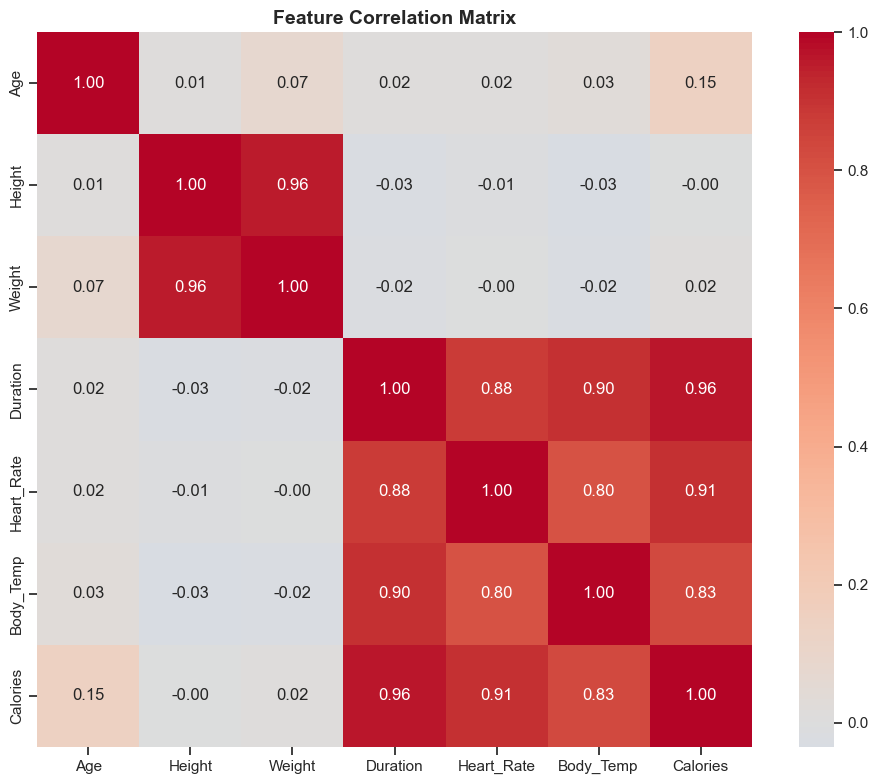


Most correlated features with target:
Calories      1.000000
Duration      0.959908
Heart_Rate    0.908748
Body_Temp     0.828671
Age           0.145683
Weight        0.015863
Height       -0.004026
Name: Calories, dtype: float64


In [46]:
# Correlation matrix
plt.figure(figsize=(10, 8))
correlation = train[numerical_features + [target_col]].corr()
sns.heatmap(correlation, annot=True, fmt='.2f', cmap='coolwarm', center=0, square=True)
plt.title('Feature Correlation Matrix', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("\nMost correlated features with target:")
print(correlation[target_col].sort_values(ascending=False))

### **Categorical Feature Summary**

In [47]:
# Sex distribution just print as percentages
print("\nSex Distribution:")
print(train['Sex'].value_counts(normalize=True) * 100)


Sex Distribution:
Sex
female    50.096133
male      49.903867
Name: proportion, dtype: float64


### **Target Variable Distribution**

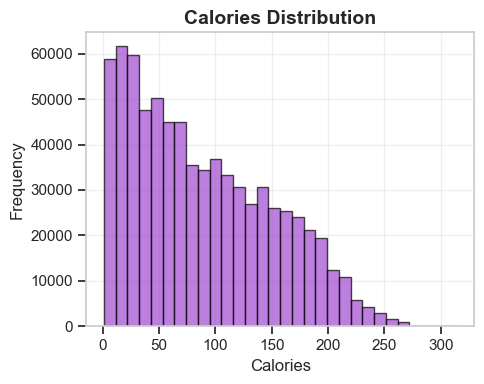

In [48]:
plt.figure(figsize=(5,4))
plt.hist(train[target_col], bins=30, color="#a149d1", edgecolor="black", alpha=0.7)
plt.title(f"{target_col} Distribution", fontsize=14, fontweight="bold")
plt.xlabel(target_col)
plt.ylabel("Frequency")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

### **Potential Issues Identified**

- **Outliers:** Z-score analysis (|z| > 3) flagged < 0.5 % of samples as potential outliers — primarily in `Body_Temp` and `Heart_Rate`. These are rare (< 0.5 %) and will be retained, as they reflect legitimate high-intensity sessions rather than data errors.

- **Feature Correlation:** The correlation matrix shows strong positive relationships between:

    - `Height` and `Weight` (0.96) — expected anthropometric link.

    - `Duration`, `Heart_Rate`, and `Body_Temp` (0.8–0.9) — plausible physiological connections.

    - All three correlate strongly with `Calories` (0.83–0.96), confirming them as the main predictors.

- **Collinearity:** The high correlation between Height and Weight could introduce multicollinearity; normalization and careful regularization during training will help mitigate this.

## **3. Data Cleaning and Normalization**

There are no missing values and no duplicates in the dataset. Most features are close to normal (low skewness). No transformations are applied.

### **Feature Engineering**

Since some features have strong correlations between them, we'll create new meaningful features to help the MLP learn non-linear relationships:

| New Feature | Formula | Motivation |
|:-------------|:---------|:-----------|
| **BMI (Body Mass Index)** | `BMI = Weight / (Height/100)^2` | Captures body composition; `Weight` and `Height` are highly correlated and redundant alone. BMI can provide a more interpretable ratio. |
| **Effort Index** | `Effort_Index = Heart_Rate * Duration` | Represents total exertion time × intensity, directly related to calorie burn. |
| **Temp_Deviation** | `Temp_Deviation = Body_Temp - Body_Temp.mean()` | Indicates thermoregulation response — people with higher deviation might burn more calories. |
| **Age_Squared** | `Age_Squared = Age ** 2` | Introduces a nonlinear age effect — metabolism might change nonlinearly with age. |
| **Log_Duration** | `Log_Duration = log(Duration + 1)` | Reduces potential scale imbalance; smooths duration’s long tail. |


In [49]:
import numpy as np

# --- Feature Engineering ---
train_fe = train.copy()

# BMI: kg/m^2
train_fe["BMI"] = train_fe["Weight"] / (train_fe["Height"] / 100) ** 2

# Exercise Intensity: heart rate per minute of duration
train_fe["Exercise_Intensity"] = train_fe["Heart_Rate"] / (train_fe["Duration"] + 1e-5)

# Temperature deviation from normal body temp (37°C)
train_fe["Temp_Diff"] = train_fe["Body_Temp"] - 37.0

# Workload index: combination of duration and heart rate
train_fe["Workload_Index"] = train_fe["Duration"] * train_fe["Heart_Rate"]

# Optional: Age group categorical bin
train_fe["Age_Group"] = pd.cut(
    train_fe["Age"],
    bins=[0, 30, 50, np.inf],
    labels=["Young", "Mid", "Old"]
)

# One-hot encode Sex and Age_Group
train_fe = pd.get_dummies(train_fe, columns=["Sex", "Age_Group"], drop_first=True)

train_fe.head()


,id,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories,BMI,Exercise_Intensity,Temp_Diff,Workload_Index,Sex_male,Age_Group_Mid,Age_Group_Old
0,0,36,189.0,82.0,26.0,101.0,41.0,150.0,22.955684,3.884614,4.0,2626.0,True,True,False
1,1,64,163.0,60.0,8.0,85.0,39.7,34.0,22.582709,10.624987,2.7,680.0,False,False,True
2,2,51,161.0,64.0,7.0,84.0,39.8,29.0,24.690405,11.999983,2.8,588.0,False,False,True
3,3,20,192.0,90.0,25.0,105.0,40.7,140.0,24.414062,4.199998,3.7,2625.0,True,False,False
4,4,38,166.0,61.0,25.0,102.0,40.6,146.0,22.136740,4.079998,3.6,2550.0,False,True,False


id                    0
Age                   0
Height                0
Weight                0
Duration              0
Heart_Rate            0
Body_Temp             0
Calories              0
BMI                   0
Exercise_Intensity    0
dtype: int64
                 BMI  Exercise_Intensity      Temp_Diff  Workload_Index
count  750000.000000       750000.000000  750000.000000   750000.000000
mean       24.374817           10.547369       3.036253     1541.562606
std         1.511310           12.237609       0.779875      932.453480
min        12.375937            2.714285       0.100000       67.000000
25%        23.255019            4.521737       2.600000      728.000000
50%        24.391059            6.214281       3.300000     1455.000000
75%        25.487697           10.749987       3.700000     2323.000000
max        46.443986          107.998920       4.500000     3840.000000


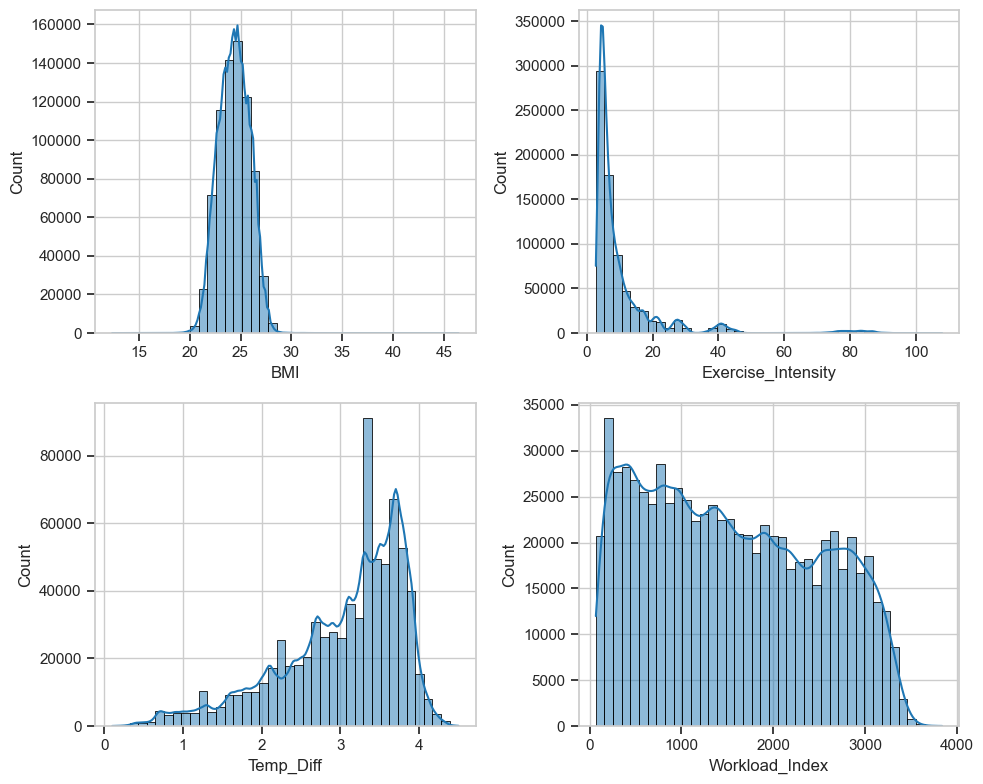

In [50]:
# Check for invalid values
print(train_fe.isna().sum().sort_values(ascending=False).head(10))
print(train_fe.describe()[["BMI","Exercise_Intensity","Temp_Diff","Workload_Index"]])

fig, axes = plt.subplots(2, 2, figsize=(10, 8))
sns.histplot(train_fe["BMI"], bins=40, kde=True, ax=axes[0,0])
sns.histplot(train_fe["Exercise_Intensity"], bins=40, kde=True, ax=axes[0,1])
sns.histplot(train_fe["Temp_Diff"], bins=40, kde=True, ax=axes[1,0])
sns.histplot(train_fe["Workload_Index"], bins=40, kde=True, ax=axes[1,1])
plt.tight_layout()
plt.show()


In [51]:
corr = train_fe.corr(numeric_only=True)["Calories"].sort_values(ascending=False)
corr

Calories              1.000000
Workload_Index        0.977341
Duration              0.959908
Heart_Rate            0.908748
Body_Temp             0.828671
Temp_Diff             0.828671
Age                   0.145683
Age_Group_Old         0.111124
BMI                   0.049226
Weight                0.015863
Sex_male              0.012011
id                    0.001148
Height               -0.004026
Age_Group_Mid        -0.008983
Exercise_Intensity   -0.560975
Name: Calories, dtype: float64